# Étude de cas : Détection de fraudes sur transactions bancaires

Dataset : https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

# Sommaire
1 Introduction

2 Présentation du dataset

3 Exploration des données (corrélation avec la cible fraud)

4 ACP

5 Modélisation

Régression logistique

Random Forest avec KFold

SVM avec ACP

XGBoost

6 Interpretation (ROC AUC)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import random
from scipy import stats
from scipy.stats import randint
import seaborn as sns

#imports ML
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [6]:
df = pd.read_csv("card_transdata.csv")
df = df.sample(frac=0.1, random_state = 42)  # 10% des données (calcul trop long)
#format
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
103200,1.293429,1.392773,1.001375,0.0,1.0,0.0,0.0,0.0
32636,4.585668,6.872228,12.091385,1.0,1.0,0.0,1.0,1.0
9291,1.774867,1.290779,24.402438,0.0,0.0,0.0,1.0,1.0
110351,544.032734,0.410699,0.162559,1.0,1.0,0.0,1.0,0.0
64704,25.787402,1.015227,0.443522,1.0,0.0,0.0,0.0,0.0


In [7]:
print(f"Le dataset contient : {df.shape}")

Le dataset contient : (27492, 8)


In [8]:
#colonnes
list(df.columns.values)

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip',
 'used_pin_number',
 'online_order',
 'fraud']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27492 entries, 103200 to 205904
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              27492 non-null  float64
 1   distance_from_last_transaction  27492 non-null  float64
 2   ratio_to_median_purchase_price  27492 non-null  float64
 3   repeat_retailer                 27492 non-null  float64
 4   used_chip                       27492 non-null  float64
 5   used_pin_number                 27492 non-null  float64
 6   online_order                    27492 non-null  float64
 7   fraud                           27492 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


La target est 'fraud', soit 0 ou 1 => classification binaire.

**Apprentissage supervisé**

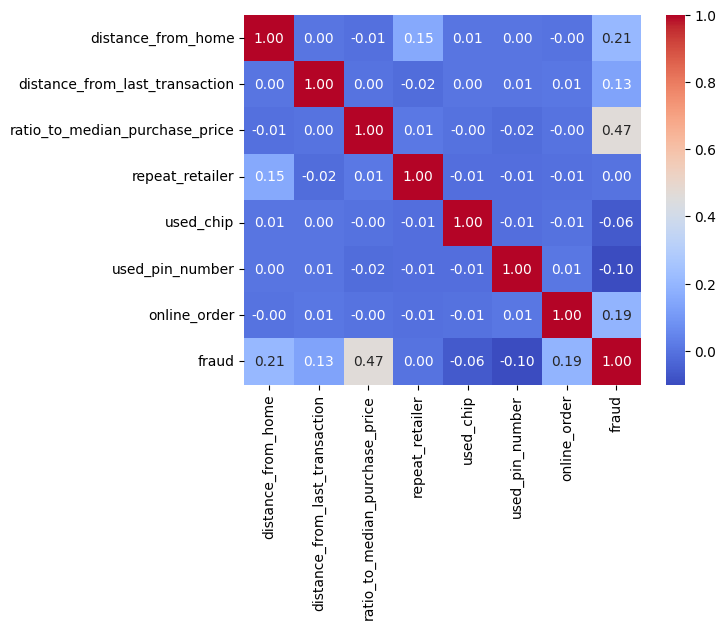

In [10]:
corr_matrix = df.corr(numeric_only=True)

# Affichage en heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


On retrouve une correlation entre fraude et :

1) ratio_to_median_purchase_price: 0.45, plus un achat est éloigné du prix habituel du client, plus il a de chances d’être frauduleux
  
2) online_order : 0.19 , fraudes plus fréquentes quand achat effectué en ligne

3) distance_from_home: 0.17 ,plus la transaction est éloignée du client, plus elle est suspecte.

distance_from_last_transaction : 0.11



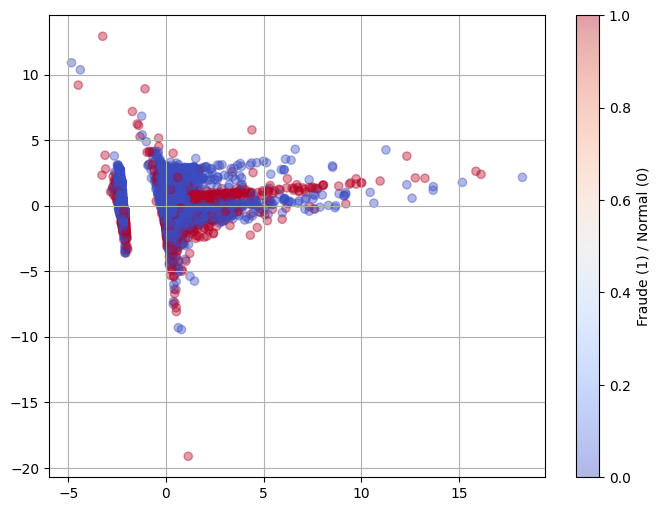

In [11]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Projection des données
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.4)
plt.colorbar(label="Fraude (1) / Normal (0)")
plt.grid(True)
plt.show()

La visualisation des deux premières composantes principales révèle que :

grande majorité des transactions se regroupent dans une région proche de l’origine --> faible variance globale

classes `fraud` et `non-fraud` ne sont pas parfaitement séparées

--> la séparation complète nécessite probablement des relations non linéaires que seule une modélisation supervisée peut capturer.


## Modèles utilisés

Le dataset étant très déséquilibré (classe "fraud" rare), 2 modèles simples:

- **Régression Logistique**
- **Random Forest** (avec GridSearchCV)

Pour Random Forest j'ai utilisé un **échantillon de 10%** du dataset pour accélérer les temps de calcul (l'interprétation n'est donc pas la même)



In [12]:
print(df.isnull().sum())
#pas de données manquantes
df.dropna().shape

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


(27492, 8)

In [13]:
np.bincount(df.duplicated())
#pas de doublons

array([27492])

In [14]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Affichage des dimensions
print(f"Dimensions des données : {X.shape}")

Dimensions des données : (27492, 7)



===== Régression Logistique =====
              precision    recall  f1-score   support

         0.0     0.9947    0.9389    0.9660      5044
         1.0     0.5827    0.9451    0.7209       455

    accuracy                         0.9394      5499
   macro avg     0.7887    0.9420    0.8435      5499
weighted avg     0.9607    0.9394    0.9458      5499



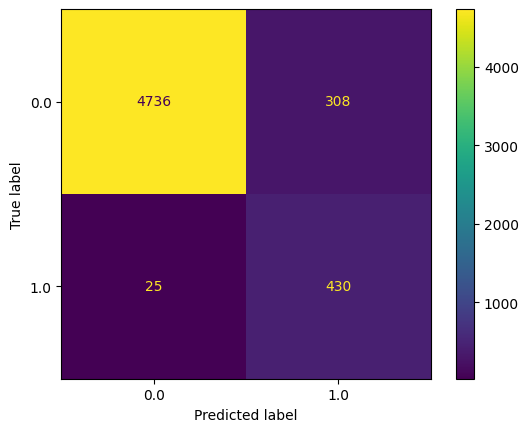

In [15]:
# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline regression logistique
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipeline_logreg.fit(X_train, y_train)
y_pred_lr = pipeline_logreg.predict(X_test)

print("\n===== Régression Logistique =====")
print(classification_report(y_test, y_pred_lr, digits=4))


disp= ConfusionMatrixDisplay.from_estimator(pipeline_logreg, X_test, y_test)
plt.show()

**Precision classe fraude:** 57,73 %

Parmi toutes les transactions classées comme "fraude", 57,73 % sont des réellement des fraudes

--> Présence de faux positifs

**Recall sur la classe fraude:** 95,11 %

Modèle capte presque toutes les fraudes qui sont réelles

**F1-score sur la classe fraude :** 71,85 %

Bon équilibre entre precision et recall.

**Accuracy globale:** 93,59 %

Pas pertinent ici (classes déséquilibrées)

===== Meilleurs paramètres RandomForest =====
{'clf__max_depth': 10, 'clf__n_estimators': 200}

===== Rapport de classification =====
              precision    recall  f1-score   support

         0.0     0.9990    1.0000    0.9995      5044
         1.0     1.0000    0.9890    0.9945       455

    accuracy                         0.9991      5499
   macro avg     0.9995    0.9945    0.9970      5499
weighted avg     0.9991    0.9991    0.9991      5499



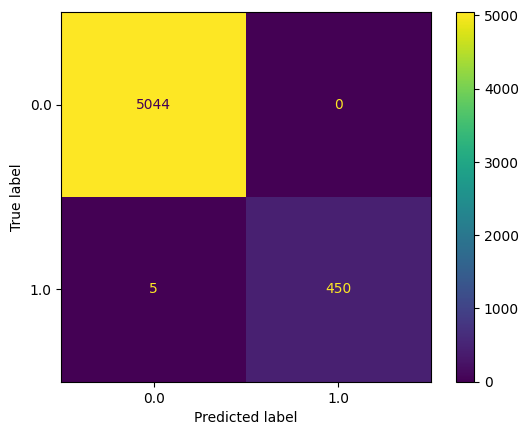

In [16]:
# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pipeline avec RandomForest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Grille d'hyperparamètres
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, 20],
}
#on peut aussi utiliser les hyperparamètres nb min split et nb min leaf

# GridSearch
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleur modèle
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Évaluation
print("===== Meilleurs paramètres RandomForest =====")
print(grid_search.best_params_)
print("\n===== Rapport de classification =====")
print(classification_report(y_test, y_pred, digits=4))

disp =ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

**Precision classe fraude:** 100 %

Parmi toutes les transactions classées comme "fraude", toutes sont réellement des fraudes

--> Aucun faux positif

**Recall sur la classe fraude:** 98,90 %

Modèle capte toutes les fraudes qui sont réelles

**F1-score sur la classe fraude :** 99,45 %

Equilibre entre precision et recall parfait.

**Accuracy globale:** 99,91 %

**Meilleurs paramètres:**

'clf__max_depth': 10

'clf__n_estimators': 100

===== Meilleurs paramètres RandomForest =====
{'clf__max_depth': 10, 'clf__n_estimators': 100}
Score moyen (F1) sur validation croisée : 0.9958

===== Rapport de classification =====
              precision    recall  f1-score   support

         0.0     0.9998    1.0000    0.9999     25111
         1.0     1.0000    0.9979    0.9989      2381

    accuracy                         0.9998     27492
   macro avg     0.9999    0.9990    0.9994     27492
weighted avg     0.9998    0.9998    0.9998     27492



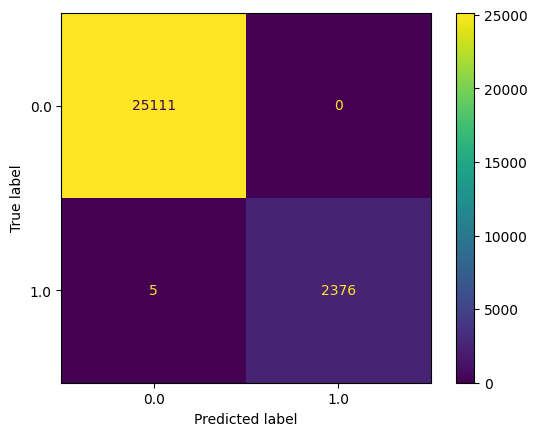

In [17]:
#on peut tester avec une validation croisée

from sklearn.model_selection import StratifiedKFold

# Pipeline Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Grille d'hyperparamètres
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, 20],
}

# Définition du validateur KFold stratifié
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch avec validation croisée
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Meilleur modèle et évaluation globale
print("===== Meilleurs paramètres RandomForest =====")
print(grid_search.best_params_)
print(f"Score moyen (F1) sur validation croisée : {grid_search.best_score_:.4f}")

# Prédictions finales sur l'ensemble
best_model_rf = grid_search.best_estimator_
y_pred = best_model.predict(X)

print("\n===== Rapport de classification =====")
print(classification_report(y, y_pred, digits=4))

disp = ConfusionMatrixDisplay.from_estimator(best_model, X, y)
plt.show()

Le modèle apprend sur des features partiellement informatives, ce qui explique qu’il puisse atteindre de très bonnes performances avec Random Forest.



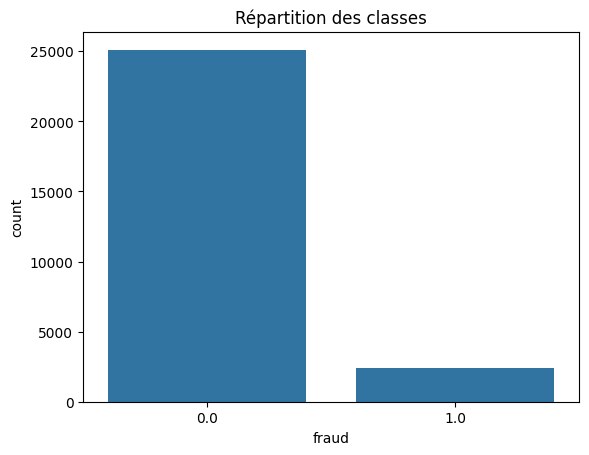

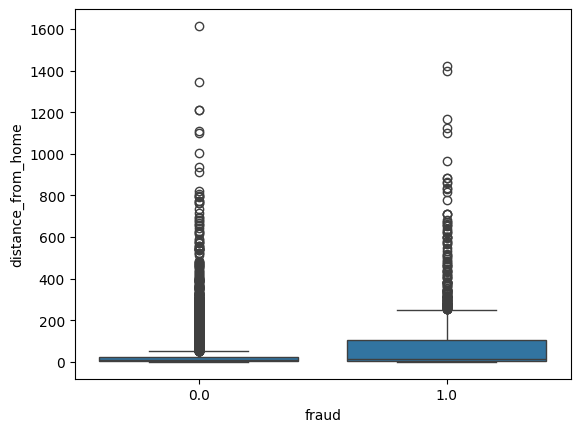

In [18]:
# Proportion de fraudes
sns.countplot(x='fraud', data=df)
plt.title("Répartition des classes")
plt.show()

# Distribution du montant vs fraude
sns.boxplot(x='fraud', y='distance_from_home', data=df)
plt.show()


In [30]:
print(X.shape[1]) #pour décider du n_components de PCA

7


Meilleurs paramètres SVM + PCA : {'pca__n_components': 7, 'svm__C': 1}

Score F<1 moyen : 0.7583531208409409

===== Rapport de classification SVM =====
              precision    recall  f1-score   support

         0.0     0.9686    0.9928    0.9805     25111
         1.0     0.8962    0.6602    0.7603      2381

    accuracy                         0.9640     27492
   macro avg     0.9324    0.8265    0.8704     27492
weighted avg     0.9623    0.9640    0.9614     27492



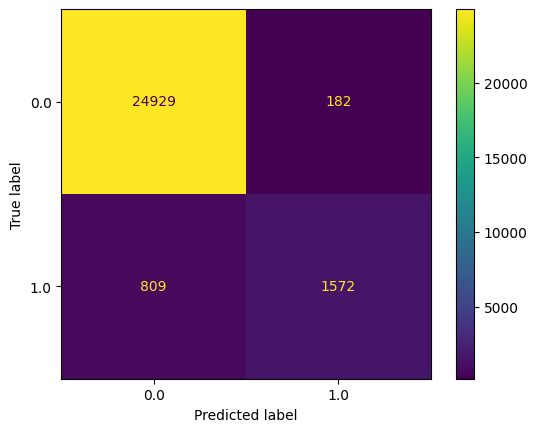

In [31]:
# GridSearch SVM linéaire avec ACP
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(kernel='linear'))
])

param_grid = {
    'pca__n_components': [2,5,7],
    'svm__C': [0.1, 1, 10]
}

grid_svm_linear = GridSearchCV(pipeline_linear, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_svm_linear.fit(X, y)

# Évaluation
print("Meilleurs paramètres SVM + PCA :", grid_svm_linear.best_params_)
print("\nScore F<1 moyen :", grid_svm_linear.best_score_)

# Prédictions finales
best_model_svm = grid_svm_linear.best_estimator_
y_pred_svm = best_model_svm.predict(X)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print("\n===== Rapport de classification SVM =====")
print(classification_report(y, y_pred_svm, digits=4))
disp = ConfusionMatrixDisplay.from_estimator(best_model_svm, X, y)
plt.show()

# XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:51:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


===== Meilleurs paramètres =====
{'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200}

===== Rapport de classification =====
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000     25111
         1.0     1.0000    1.0000    1.0000      2381

    accuracy                         1.0000     27492
   macro avg     1.0000    1.0000    1.0000     27492
weighted avg     1.0000    1.0000    1.0000     27492



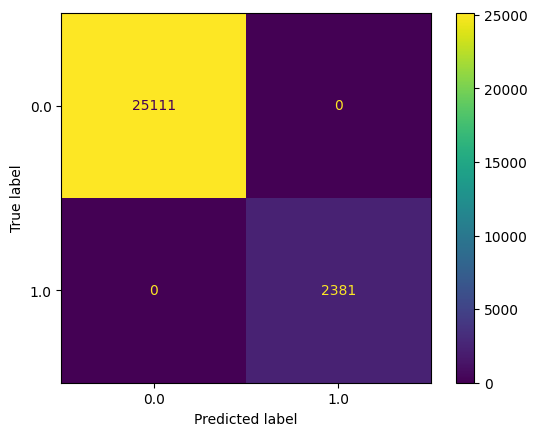

In [32]:
from xgboost import XGBClassifier

# Pipeline XGBoost
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Grille pour test
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.1, 0.3]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X, y)

# Meilleur modèle
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print("===== Meilleurs paramètres =====")
print(grid_search_xgb.best_params_)
print("\n===== Rapport de classification =====")
print(classification_report(y, y_pred_xgb, digits=4))

disp = ConfusionMatrixDisplay.from_estimator(best_model_xgb, X, y)
plt.show()

Le modèle a été entraîné avec les meilleurs hyperparamètres:

max_depth = 5

n_estimators = 200

learning_rate = 0.3

Et on obtient les résultats suivant:

F1-score: 100%

Recall: 100 %

Accuracy : 100 %

très bons modèle pour la détection de fraude


# Courbes ROC AUC

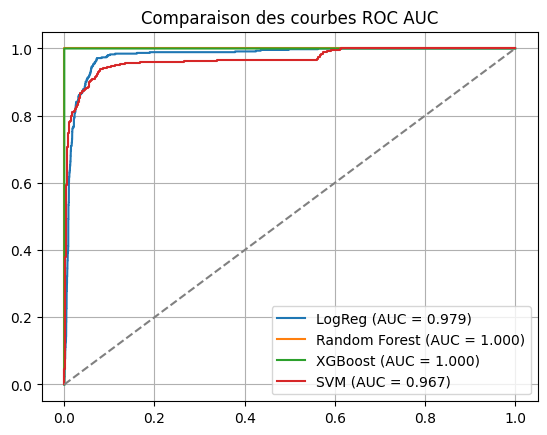

In [33]:
#regression logistique
y_proba_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_logreg)
auc_log = roc_auc_score(y_test, y_proba_logreg)
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC = {auc_log:.3f})")

# random forest
y_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

#XGBoost
y_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")

#SVM
y_proba_svm = best_model_svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Comparaison des courbes ROC AUC")
plt.legend()
plt.grid()
plt.show()


## Interprétation

**SVM**: AUC = 0.967

**Régression Logistique**: AUC = 0.98  

Très bonne performance pour un modèle linéaire simple

Bon rappel, mais plus de FP que les autres modèles

**Random Forest**: AUC=1.0

Résultat parfait sur les données --> le modèle capture très bien les patterns de fraude

À relativiser car cela peut venir de la structure du dataset.

**XGBoost**: AUC=1.00  

Performance également parfaite..  

Résultat réaliste ici, mais à réévaluer sur données bruitées ou en production.

--> les deux modèles à base d’arbres (RF et XGB) surperforment logiquement

la régression logistique reste néanmoins un excellent modèle de base rapide et interprétable.
